# <font color = 'indianred'>**QuestionAnswering-Inference** </font>


## Outline
1. **Setting up the Environment**: Installing necessary libraries and setting up paths.
2. **Creating Huggingface Dataset for Custom Dataset**: Understanding the structure and content of the dataset.

3. **Data Preprocessing**: Techniques to prepare the data for training, including handling different data splits and tokenization
4. **Training the Model**: Feeding data and adjusting weights.
5. **Inference**: Evaluate model on test set and making predictions.



# <font color = 'indianred'> **Setting up the Environment** </font>



In [52]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder = Path("/content/drive/MyDrive/data")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")


from transformers import  AutoModelForQuestionAnswering, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, pipeline
from datasets import load_dataset, DatasetDict, Dataset
import evaluate

import torch

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import textwrap

In [10]:
def print_wrap(text, d, highlight = False,highlight_word = None):
    # If the text is a list, convert it to a string
    if isinstance(text, list):
        # Convert None values to a default string (e.g., "None" or an empty string)
        text = ' '.join(str(item) if item is not None else "None" for item in text)

    if highlight:
        # Highlight the word
        text = text.replace(highlight_word, f'\033[91m{highlight_word}\033[0m')
    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)

    
def print_wrap_dict(data, d):
    for key, value in data.items():
        # Wrap and print the key
        wrapped_key = textwrap.fill(key + ':', width=d)
        print(wrapped_key, end=' ')

        # Convert the list values to a string and wrap it
        value_string = ', '.join(map(str, value))
        wrapped_value = textwrap.fill(value_string, width=d, subsequent_indent=' ' * (len(key) + 2))

        # Print the wrapped value
        print(wrapped_value)
        

# <font color = 'indianred'> **Exploring and Understanding Dataset**

## <font color = 'indianred'> **Load Data set** 


In [11]:
raw_datasets = load_dataset('subjqa', name = 'electronics')

In [12]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})

## <font color = 'indianred'> **Understanding your data**

## <font color = 'indianred'> **Understanding the datatype of columns**


In [13]:
raw_datasets['train'].features

{'domain': Value(dtype='string', id=None),
 'nn_mod': Value(dtype='string', id=None),
 'nn_asp': Value(dtype='string', id=None),
 'query_mod': Value(dtype='string', id=None),
 'query_asp': Value(dtype='string', id=None),
 'q_reviews_id': Value(dtype='string', id=None),
 'question_subj_level': Value(dtype='int64', id=None),
 'ques_subj_score': Value(dtype='float32', id=None),
 'is_ques_subjective': Value(dtype='bool', id=None),
 'review_id': Value(dtype='string', id=None),
 'id': Value(dtype='string', id=None),
 'title': Value(dtype='string', id=None),
 'context': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None), 'answer_subj_level': Value(dtype='int64', id=None), 'ans_subj_score': Value(dtype='float32', id=None), 'is_ans_subjective': Value(dtype='bool', id=None)}, length=-1, id=None)}

## <font color = 'indianred'> **Acess indivdual element** </font>


In [14]:
# get the first example of the dataset
raw_datasets['train'][1]


{'domain': 'electronics',
 'nn_mod': 'harsh',
 'nn_asp': 'high',
 'query_mod': 'not strong',
 'query_asp': 'bass',
 'q_reviews_id': '7c46670208f7bf5497480fbdbb44561a',
 'question_subj_level': 1,
 'ques_subj_score': 0.5,
 'is_ques_subjective': False,
 'review_id': 'ce76793f036494eabe07b33a9a67288a',
 'id': 'd476830bf9282e2b9033e2bb44bbb995',
 'title': 'B00001P4ZH',
 'context': 'To anyone who hasn\'t tried all the various types of headphones, it is important to remember exactly what these are: cheap portable on-ear headphones. They give a totally different sound then in-ears or closed design phones, but for what they are I would say they\'re good. I currently own six pairs of phones, from stock apple earbuds to Sennheiser HD 518s. Gave my Portapros a run on both my computer\'s sound card and mp3 player, using 256 kbps mp3s or better. The clarity is good and they\'re very lightweight. The folding design is simple but effective. The look is certainly retro and unique, although I didn\'t fi

In [15]:
print_wrap(raw_datasets['train']['question'][1], 80)

Is this music song have a goo bass?


In [16]:
print_wrap(raw_datasets['train']['context'][1], 80)

To anyone who hasn't tried all the various types of headphones, it is important
to remember exactly what these are: cheap portable on-ear headphones. They give
a totally different sound then in-ears or closed design phones, but for what
they are I would say they're good. I currently own six pairs of phones, from
stock apple earbuds to Sennheiser HD 518s. Gave my Portapros a run on both my
computer's sound card and mp3 player, using 256 kbps mp3s or better. The clarity
is good and they're very lightweight. The folding design is simple but
effective. The look is certainly retro and unique, although I didn't find it as
comfortable as many have claimed. Earpads are *very* thin and made my ears sore
after 30 minutes of listening, although this can be remedied to a point by
adjusting the "comfort zone" feature (tightening the temple pads while loosening
the ear pads). The cord seems to be an average thickness, but I wouldn't get too
rough with these. The steel headband adjusts smoothly and e

In [17]:
# get label of last ten examples
print_wrap_dict(raw_datasets['train']['answers'][1], 80)

text: Bass is weak as expected, Bass is weak as expected, even with EQ adjusted up
answer_start: 1302, 1302
answer_subj_level: 1, 1
ans_subj_score: 0.5083333253860474, 0.5083333253860474
is_ans_subjective: True, True


## <font color = 'indianred'> **Exploratory Data Analysis (EDA)**

In [18]:
raw_datasets['train'][0]

{'domain': 'electronics',
 'nn_mod': 'great',
 'nn_asp': 'bass response',
 'query_mod': 'excellent',
 'query_asp': 'bass',
 'q_reviews_id': '0514ee34b672623dff659334a25b599b',
 'question_subj_level': 5,
 'ques_subj_score': 0.5,
 'is_ques_subjective': False,
 'review_id': '882b1e2745a4779c8f17b3d4406b91c7',
 'id': '2543d296da9766d8d17d040ecc781699',
 'title': 'B00001P4ZH',
 'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.

In [19]:
# set dataset tp pandas dataframe
train_df = raw_datasets['train'].to_pandas()


In [20]:
train_df.head()

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers
0,electronics,great,bass response,excellent,bass,0514ee34b672623dff659334a25b599b,5,0.50,False,882b1e2745a4779c8f17b3d4406b91c7,2543d296da9766d8d17d040ecc781699,B00001P4ZH,"I have had Koss headphones in the past, Pro 4A...",How is the bass?,"{'text': [], 'answer_start': [], 'answer_subj_..."
1,electronics,harsh,high,not strong,bass,7c46670208f7bf5497480fbdbb44561a,1,0.50,False,ce76793f036494eabe07b33a9a67288a,d476830bf9282e2b9033e2bb44bbb995,B00001P4ZH,To anyone who hasn't tried all the various typ...,Is this music song have a goo bass?,"{'text': ['Bass is weak as expected', 'Bass is..."
2,electronics,neutral,sound,present,bass,8fbf26792c438aa83178c2d507af5d77,1,0.50,False,d040f2713caa2aff0ce95affb40e12c2,455575557886d6dfeea5aa19577e5de4,B00001P4ZH,I have had many sub-$100 headphones from $5 Pa...,How is the bass?,{'text': ['The only fault in the sound is the ...
3,electronics,muddy,bass,awesome,bass,9876fd06ed8f075fcad70d1e30e7e8be,1,0.50,False,043e7162df91f6ea916c790c8a6f6b22,6895a59b470d8feee0f39da6c53a92e5,B00001WRSJ,My sister's Bose headphones finally died and s...,How is the audio bass?,"{'text': ['the best of all of them'], 'answer_..."
4,electronics,perfect,bass,incredible,sound,16506b53e2d4c2b6a65881d9462256c2,1,0.65,True,29ccd7e690050e2951be49289e915382,7a2173c502da97c5bd5950eae7cd7430,B00001WRSJ,Wow. Just wow. I'm a 22 yr old with a crazy ob...,Why do I have an incredible sound?,"{'text': ['The sound is so crisp', 'crazy obse..."


In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   domain               1295 non-null   object 
 1   nn_mod               1295 non-null   object 
 2   nn_asp               1295 non-null   object 
 3   query_mod            1295 non-null   object 
 4   query_asp            1295 non-null   object 
 5   q_reviews_id         1295 non-null   object 
 6   question_subj_level  1295 non-null   int64  
 7   ques_subj_score      1295 non-null   float32
 8   is_ques_subjective   1295 non-null   bool   
 9   review_id            1295 non-null   object 
 10  id                   1295 non-null   object 
 11  title                1295 non-null   object 
 12  context              1295 non-null   object 
 13  question             1295 non-null   object 
 14  answers              1295 non-null   object 
dtypes: bool(1), float32(1), int64(1), obje

**Conclusions:**



### <font color = 'indianred'> **Check length of the reviews** </font>


In [22]:
# Calculate words per review
train_df['words_per_context'] = train_df['context'].str.split().apply(len)
train_df['words_per_question'] = train_df['question'].str.split().apply(len)

In [23]:
train_df

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers,words_per_context,words_per_question
0,electronics,great,bass response,excellent,bass,0514ee34b672623dff659334a25b599b,5,0.50,False,882b1e2745a4779c8f17b3d4406b91c7,2543d296da9766d8d17d040ecc781699,B00001P4ZH,"I have had Koss headphones in the past, Pro 4A...",How is the bass?,"{'text': [], 'answer_start': [], 'answer_subj_...",118,4
1,electronics,harsh,high,not strong,bass,7c46670208f7bf5497480fbdbb44561a,1,0.50,False,ce76793f036494eabe07b33a9a67288a,d476830bf9282e2b9033e2bb44bbb995,B00001P4ZH,To anyone who hasn't tried all the various typ...,Is this music song have a goo bass?,"{'text': ['Bass is weak as expected', 'Bass is...",395,8
2,electronics,neutral,sound,present,bass,8fbf26792c438aa83178c2d507af5d77,1,0.50,False,d040f2713caa2aff0ce95affb40e12c2,455575557886d6dfeea5aa19577e5de4,B00001P4ZH,I have had many sub-$100 headphones from $5 Pa...,How is the bass?,{'text': ['The only fault in the sound is the ...,397,4
3,electronics,muddy,bass,awesome,bass,9876fd06ed8f075fcad70d1e30e7e8be,1,0.50,False,043e7162df91f6ea916c790c8a6f6b22,6895a59b470d8feee0f39da6c53a92e5,B00001WRSJ,My sister's Bose headphones finally died and s...,How is the audio bass?,"{'text': ['the best of all of them'], 'answer_...",303,5
4,electronics,perfect,bass,incredible,sound,16506b53e2d4c2b6a65881d9462256c2,1,0.65,True,29ccd7e690050e2951be49289e915382,7a2173c502da97c5bd5950eae7cd7430,B00001WRSJ,Wow. Just wow. I'm a 22 yr old with a crazy ob...,Why do I have an incredible sound?,"{'text': ['The sound is so crisp', 'crazy obse...",133,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1290,electronics,great,impression,rubbery,feel,d4409d6272a7d1d5aa287d6e164bb7d0,1,0.00,False,ebaaec25661c0b21f3e5600a1ed7e30b,e0ea72e711324b5482ec1b36a48f16ee,B00H3OYSHW,I ordered my new NewTrend Airbender Pro NT610K...,Where can I feel my device?,"{'text': [], 'answer_start': [], 'answer_subj_...",582,6
1291,electronics,tight,case,great,protection,ed6533390fe2fe0d546b69dea570c34b,5,0.00,False,ebaaec25661c0b21f3e5600a1ed7e30b,ee5906ed3306b7c6d219a40adae2c7c2,B00H3OYSHW,I ordered my new NewTrend Airbender Pro NT610K...,How does the selector protection me?,"{'text': [], 'answer_start': [], 'answer_subj_...",582,6
1292,electronics,good,texture,good,grip,22b23446daf9d5bc0140be7278b220ee,1,0.00,False,84efbd9643d7f43af0ea0d2468c7dcc9,a541ffd9697ebf0ad9d226428594128e,B00HNGB1YS,"After using this case for a few days, I have g...",How is the grip?,"{'text': [], 'answer_start': [], 'answer_subj_...",339,4
1293,electronics,easy to use,keyboard,removable,keyboard,e7967ad5be0658b4acfca1118f6af1ab,1,0.00,False,e856d7e5351e3385b5d75f06562e905b,7efc5e7ffaa79f53cc50f76a44f9f88e,B00HPM1G8Q,Edit 4/21/14. I finally caved and purchased a ...,How is the keyboard?,"{'text': ['the keyboard is very easy to use', ...",398,4


#### <font color = 'indianred'> **Plot the distribution of review length** </font>

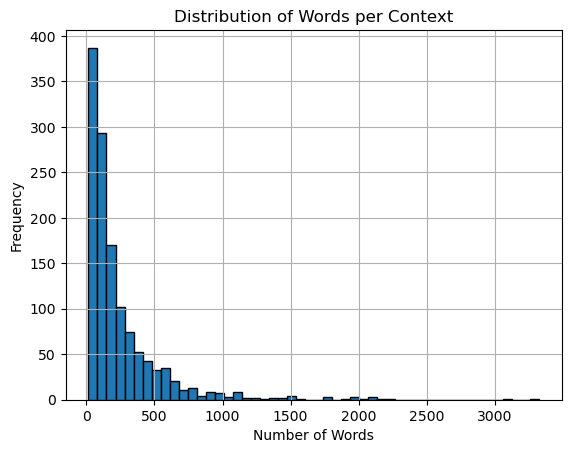

In [24]:
# Plot a histogram of the 'words_per_context' column
train_df['words_per_context'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Context')

# Display the plot
plt.show()


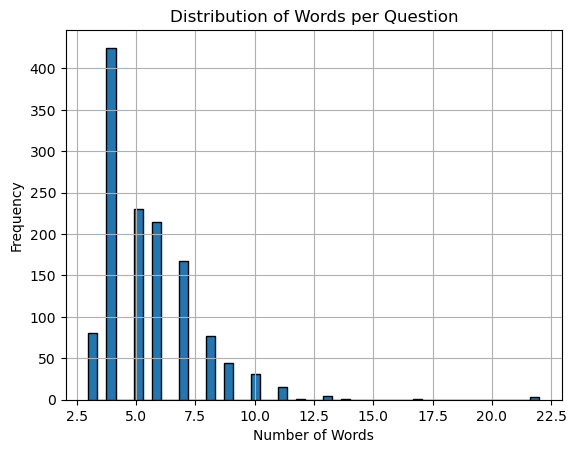

In [25]:
# Plot a histogram of the 'words_per_review' column
train_df['words_per_question'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Question')

# Display the plot
plt.show()

# <font color = 'indianred'> **Data Pre-processing**</font>

No pre-processing required for this dataset

## <font color = 'indianred'> **Tokenization**</font>



In [26]:
# Define a checkpoint for the DistilBERT model with an uncased vocabulary.
# Instantiate the tokenizer for this model using the specified checkpoint.
checkpoint = 'deepset/minilm-uncased-squad2'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [27]:
question = "When did the Mars Rover land on Mars?"
context = "NASA's Mars Rover, named Perseverance, landed on Mars in February 2021. Its mission is to search for signs of ancient life and collect samples of Martian rock and regolith (broken rock and dust)."

In [28]:
inputs = tokenizer(question, context, return_tensors='pt')

In [29]:
inputs

{'input_ids': tensor([[  101,  2043,  2106,  1996,  7733, 13631,  2455,  2006,  7733,  1029,
           102,  9274,  1005,  1055,  7733, 13631,  1010,  2315,  2566,  3366,
         21998,  1010,  5565,  2006,  7733,  1999,  2337, 25682,  1012,  2049,
          3260,  2003,  2000,  3945,  2005,  5751,  1997,  3418,  2166,  1998,
          8145,  8168,  1997, 20795,  2600,  1998, 19723, 10893,  2705,  1006,
          3714,  2600,  1998,  6497,  1007,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [31]:
print_wrap(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), 80)

[CLS] when did the mars rover land on mars ? [SEP] nasa ' s mars rover , named
per ##se ##verance , landed on mars in february 2021 . its mission is to search
for signs of ancient life and collect samples of martian rock and reg ##oli ##th
( broken rock and dust ) . [SEP]


In [32]:
print_wrap(tokenizer.decode(inputs['input_ids'][0]), 80)

[CLS] when did the mars rover land on mars? [SEP] nasa's mars rover, named
perseverance, landed on mars in february 2021. its mission is to search for
signs of ancient life and collect samples of martian rock and regolith ( broken
rock and dust ). [SEP]


##  <font color = 'indianred'> **Download pre-trained model**

In [33]:
model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)


In [34]:
model.config

BertConfig {
  "_name_or_path": "deepset/minilm-uncased-squad2",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

## <font color = 'indianred'> **Understanding Model Outputs**</font>

In [36]:
with torch.no_grad():
    outputs = model(**inputs)   


In [39]:
print_wrap_dict(outputs, 100)

start_logits: tensor([-1.1873, -4.9677, -5.7363, -5.7316, -5.6144, -5.8061, -5.5011, -5.6903,         -5.8508,
              -6.3096, -1.1873, -3.2757, -6.1794, -5.7731, -2.3183, -4.1852,         -5.8967,
              -5.1778, -3.1052, -5.9756, -5.8803, -5.1572, -2.3314, -4.2585,         -3.2766,
              1.1665,  7.0122,  2.4858, -3.8798, -5.5178, -6.0760, -6.3400,         -6.0360,
              -6.0346, -6.2708, -6.2477, -6.3804, -6.1675, -6.6107, -6.6208,         -6.1926,
              -6.3451, -6.4412, -5.7917, -6.4295, -6.5530, -6.1729, -6.5433,         -6.7728,
              -6.4534, -6.1032, -6.5498, -6.5319, -6.5847, -6.7076, -6.5765,         -1.1873])
end_logits: tensor([-1.0864, -6.0949, -6.1854, -6.1834, -6.3787, -6.0049, -6.1165, -6.3017,         -5.4296,
            -5.4423, -1.0864, -4.7570, -5.3265, -5.0272, -4.6786, -4.3516,         -4.5631, -6.2934,
            -6.0708, -5.5585, -3.1038, -2.5731, -4.5817, -5.8118,         -2.7584, -4.4399,  1.1848,
            7.

In [41]:
print(outputs['start_logits'].shape)
print(outputs['end_logits'].shape)
print(inputs.input_ids.shape)    

torch.Size([1, 57])
torch.Size([1, 57])
torch.Size([1, 57])


## <font color = 'indianred'> **Get the Final Answer**</font>

In [42]:
start_idx = torch.argmax(outputs['start_logits'])
end_idx = torch.argmax(outputs['end_logits'])+1
answer_span = inputs['input_ids'][0][start_idx:end_idx]


In [43]:
answer_span

tensor([ 2337, 25682])

In [46]:
answer = tokenizer.decode(answer_span)

In [49]:
print_wrap(question, 80)

When did the Mars Rover land on Mars?


In [50]:

print_wrap(answer, 80)

february 2021


##  <font color = 'indianred'> **QA Pipeline**</font>

In [53]:
qa_pipeline = pipeline('question-answering', model = checkpoint, tokenizer = checkpoint)

In [69]:
qa_pipeline(question = question, context = context, topk = 3)

/home/harpreet/mambaforge/lib/python3.10/site-packages/transformers/pipelines/question_answering.py:323: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.9731668829917908,
  'start': 57,
  'end': 70,
  'answer': 'February 2021'},
 {'score': 0.010529509745538235, 'start': 66, 'end': 70, 'answer': '2021'},
 {'score': 0.009463440626859665,
  'start': 57,
  'end': 71,
  'answer': 'February 2021.'}]

In [ ]:
qa_pipeline(question = question, context = context, topk = 3, handle_impossible_answer = True)